Spike-phase coupling and decoding: 
Phase precession and hippocampal sequences
==========================================

In this tutorial we will learn how to apply two methods included in pynapple: filtering and decoding. We'll apply these methods to demonstrate and visualize some well-known physiological properties of hippocampal activity, specifically phase presession of place cells and sequential coordination of place cell activity during theta oscillations.

Pynapple functions used:
- load_file
- restrict
- compute_wavelet_transform
- apply_bandpass_filter
- compute_1d_tuning_curves
- value_from
- set_diff
- count
- convolve
- decode_1d

Background
----------
- hippocampus (rat)
- place cells
- LFP and theta oscillation
- phase precession
- theta sequences

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynapple as nap
import pynacollada as nac

# necessary for animation
import nemos as nmo
plt.style.use(nmo.styles.plot_style)

***
Fetching the data
--------------------
The data set we'll be looking at is from the manuscript [Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences](https://www.science.org/doi/10.1126/science.aad1935). In this study, the authors collected electrophisiology data in rats across multiple sites in layer CA1 of hippocampus to extract the LFP alongside spiking activity of many simultaneous pyramidal units. In each recording session, data were collected while the rats explored a novel environment (a linear track), as well as during sleep before and after exploration. In our following analyses, we'll focus on the exploration period of a single rat and recording session.

The full dataset for this study can be accessed on [DANDI](https://dandiarchive.org/dandiset/000044/0.210812.1516). Since the file size of a recording session can be large from the LFP saved for each recorded channel, we'll use a smaller file that contains the spiking activity and the LFP from a single, representative channel, which is hosted on [OSF](https://osf.io/2dfvp). This smaller file, like the original data, is saved as an [NWB](https://www.nwb.org) file.

If you ran the workshop setup script, you should have this file downloaded already. If not, the function we'll use to fetch it will download it for you. This function is called `fetch_data`, and can be imported from the `workshop_utils` module.

In [2]:
path = nac.fetch_data("place_cells")

This function will give us the file path to where the data is stored. We can then use the pynapple function `load_file` to load in the data, which is able to handle the NWB file type.

In [3]:
data = nac.load_data("place_cells")
print(data)

/opt/homebrew/Caskroom/miniforge/base/envs/nac-dev/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/homebrew/Caskroom/miniforge/base/envs/nac-dev/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/homebrew/Caskroom/miniforge/base/envs/nac-dev/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


What this gives you is a dictionary of pynapple objects that have been inferred from the NWB file. This dictionary contains the following fields:
- `units`: a `TsGroup` with each units spike times as well as metadata about each unit (i.e. location, shank, and cell type). This dataset contains 137 units all in CA1.
- `rem`: an `IntervalSet` of REM sleep epochs, with 3 occuring before exploration and 1 occuring after.
- `nrem`: an `IntervalSet` of nREM sleep epochs, with 6 occuring before exploration and 5 occuring after.
- `forward_ep`: an `IntervalSet` containing each time window when the animal crossed the linear track in one direction. There are a total of 84 traversals in this session.
- `eeg`: a `TsdFrame` containing an LFP voltage traces for a single representative channel in CA1.
- `theta_phase`: a `Tsd` with the computed theta phase of the LFP used in the study. We will be computing this ourselves.
- `position`: a `Tsd` containing the linearized position

***
Filtering the data
------------------
For the following exercises, we'll only focus on the exploration epochs contained in `forward_ep`. Therefore, when extracting the LFP, spikes, and position, we can use `restrict()` with the `forward_ep` IntervalSet to subselect the data.

In [4]:
lfp_run = data["eeg"][:,0].restrict(data["forward_ep"])
spikes = data["units"].restrict(data["forward_ep"])
position = data["position"].restrict(data["forward_ep"])

For visualization, we'll look at a single run down the linear track. For a good example, we'll start by looking at run 10 (python index 9). It is encouraged, however, to repeat these exercises on additional runs!

In [5]:
ex_run_ep = data["forward_ep"][9]

***
Plotting the LFP and animal position
------------------------------------
To get a sense of what the LFP looks like while the animal runs down the linear track, we can plot each variable, `lfp_run` and `position`, side-by-side. We'll want to further restrict each variable to our run of interest stored in `ex_run_ep`.

In [6]:
ex_lfp_run = lfp_run.restrict(ex_run_ep)
ex_position = position.restrict(ex_run_ep)

By default, plotting Tsd objects will use the time index on the x-axis. However, for a more interpretable time axis, we'll subtract the first time index from each variable's time indices and pass it as the first argument in matplotlib's `plot`. This will give the relative time elapsed on the current run.

Text(0.5, 0, 'time (s)')

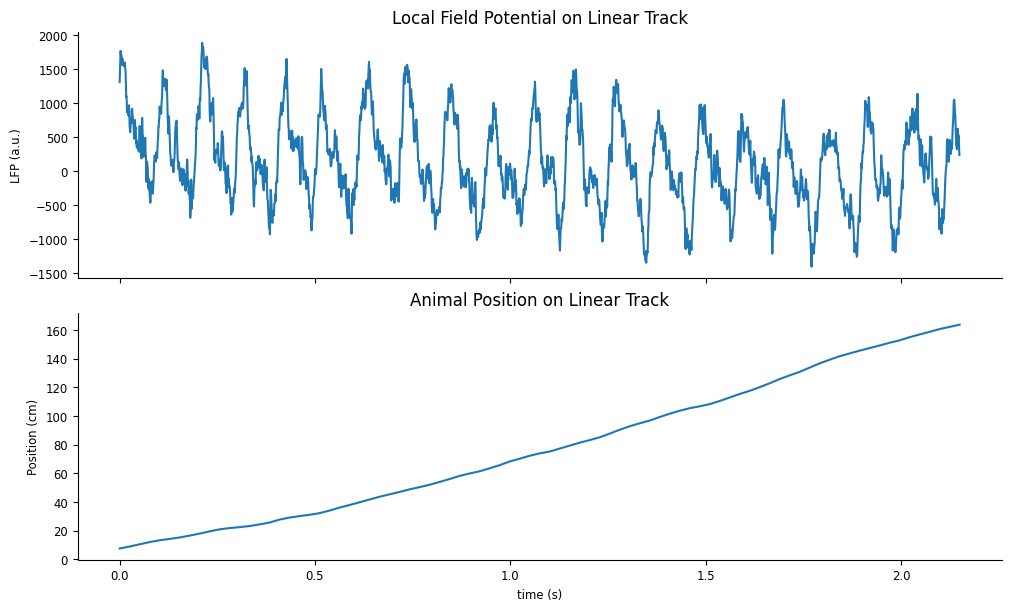

In [7]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6), sharex=True)

# plot LFP
axs[0].plot(ex_lfp_run.index - ex_lfp_run.index[0], ex_lfp_run)
axs[0].set_title("Local Field Potential on Linear Track")
axs[0].set_ylabel("LFP (a.u.)")

# plot animal's position
axs[1].plot(ex_position.index - ex_position.index[0], ex_position)
axs[1].set_title("Animal Position on Linear Track")
axs[1].set_ylabel("Position (cm)") # LOOK UP UNITS
axs[1].set_xlabel("time (s)")

***
Getting the Wavelet Decomposition
-----------------------------------
As we would expect, there is a strong theta oscillation dominating the LFP while the animal runs down the track. To illustrate this further, we'll perform a wavelet decomposition on the LFP trace during this run.

DEFINE WAVELET DECOMPOSITION

We must define the frequency set that we'd like to use for our decomposition. We can do this with the numpy function `np.geomspace`, which returns numbers evenly spaced on a log scale. We pass the lower frequency, the upper frequency, and number of samples as positional arguments.

In [8]:
# 25 log-spaced samples between 5Hz and 200Hz
freqs = np.geomspace(5, 200, 100)

We can now compute the wavelet transform on our LFP data during the example run using the pynapple function `nap.compute_wavelet_trasform`, which takes the time series and array of frequencies as positional arguments. Optionally, we can pass the keyword argument `fs` to provide the the sampling frequency, which is known to be 1250Hz from the study methods.

double check: FS back tracked to https://www.jneurosci.org/content/28/26/6731 methods

In [9]:
sample_freq = 1250  # We know from the methods of the paper
cwt_run = nap.compute_wavelet_transform(lfp_run.restrict(ex_run_ep), freqs, fs=sample_freq)

If `fs` is not provided, it can be inferred from the time series `rate` attribute, which matches what was pulled from the methods

In [10]:
print(ex_lfp_run.rate)

1250.0043532744537


We can visualize the results by plotting a heat map of the calculated wavelet scalogram.

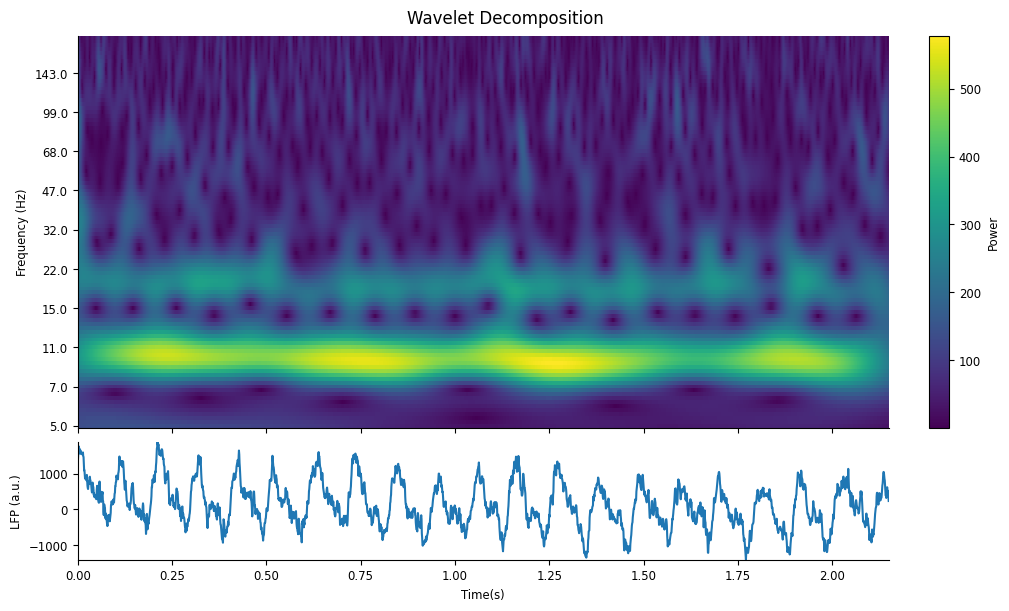

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10,6), constrained_layout=True, height_ratios=[1.0, 0.3], sharex=True)
fig.suptitle("Wavelet Decomposition")

t = ex_lfp_run.index - ex_lfp_run.index[0]
power = np.abs(cwt_run.values)
cax = axs[0].pcolormesh(t, freqs, power.T)
axs[0].set(ylabel="Frequency (Hz)", yscale='log', yticks=freqs[::10], yticklabels=np.rint(freqs[::10]));
axs[0].minorticks_off()
fig.colorbar(cax,label="Power")

axs[1].plot(t, ex_lfp_run)
axs[1].set(ylabel="LFP (a.u.)", xlabel="Time(s)")
axs[1].margins(0)

***
Filtering for theta
-------------------
We can extract the theta oscillation by applying a bandpass filter on the raw LFP. To do this, we use the pynapple function `nap.apply_bandpass_filter`, which takes the time series as the first argument and the frequency cutoffs as the second argument. Similarly to `nap.compute_wavelet_transorm`, we can optinally pass the sampling frequency keyword argument `fs`.

Conveniently, this function will recognize and handle splits in the epoched data (i.e. applying the filtering separately to discontinuous epochs), so we can pass the LFP for all the runs together.

In [12]:
theta_band = nap.apply_bandpass_filter(lfp_run, (6.0, 12.0), fs=sample_freq)

We can visualize the output by plotting the filtered signal with the original signal.

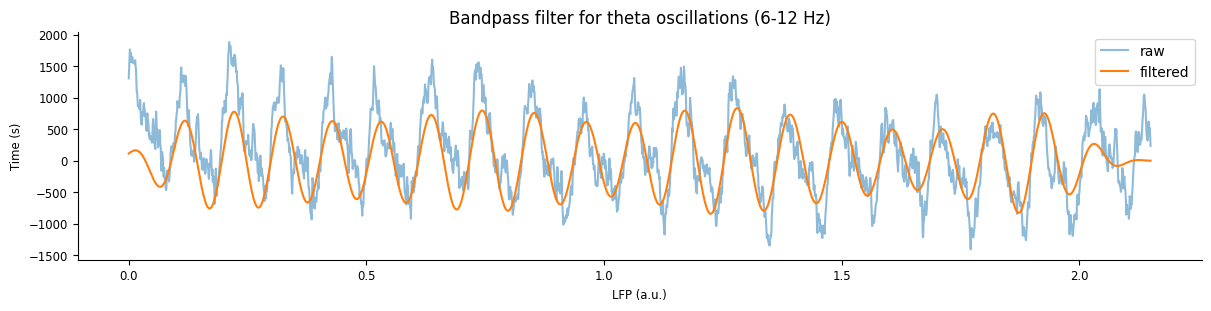

In [13]:
plt.figure(constrained_layout=True, figsize=(12, 3))
plt.plot(t, ex_lfp_run, alpha=0.5, label="raw")
plt.plot(t, theta_band.restrict(ex_run_ep), label="filtered")
plt.ylabel("Time (s)")
plt.xlabel("LFP (a.u.)")
plt.title("Bandpass filter for theta oscillations (6-12 Hz)")
plt.legend();

***
Computing phase
---------------
In order to examine phase precession in place cells, we need to extract the phase of theta from the filtered signal. We can do this by taking the angle of the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform).

The `signal` module of `scipy` includes a function to perform the Hilbert transform, after which we can use the numpy function `np.angle` to extract the angle.

In [14]:
from scipy import signal

phase = np.angle(signal.hilbert(theta_band)) # compute phase with hilbert transform
phase[phase < 0] += 2 * np.pi # wrap to [0,2pi]
theta_phase = nap.Tsd(t=theta_band.t, d=phase)

Let's plot the phase on top of the filtered LFP signal.

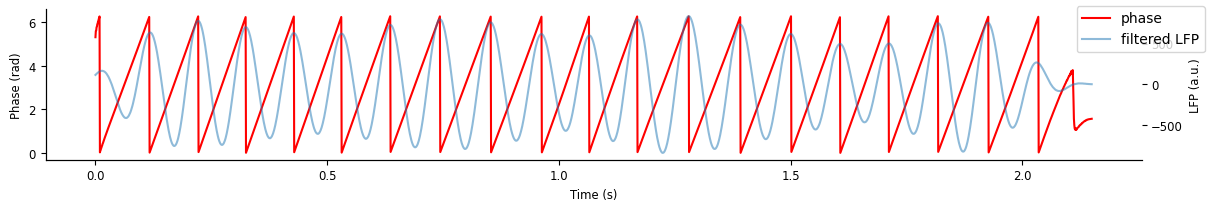

In [15]:
fig,ax = plt.subplots(figsize=(12,2), constrained_layout=True) #, sharex=True, height_ratios=[2,1])

ax.plot(t, theta_phase.restrict(ex_run_ep), color='r', label="phase")
ax.set_ylabel("Phase (rad)")
ax.set_xlabel("Time (s)")
ax = ax.twinx()
ax.plot(t, theta_band.restrict(ex_run_ep), alpha=0.5, label="filtered LFP")
ax.set_ylabel("LFP (a.u.)")
fig.legend()

We can see that cycle "resets" (i.e. goes from $2\pi$ to $0$) at peaks of the theta oscillation.

***
Identifying place-selective cells
---------------------------------
In order to identify phase precession in individual units, we need to know their place selectivity. We can find place firing preferences
of each unit by using the `compute_1d_tuning_curves` function.

We'll start by narrowing down our cells to lower-firing, putative pyramidal cells, or units that fire between 1 and 10 Hz on average, to reduce to units that are likely selective to a single location. These units will give us the clearest examples of phase precession.

In [16]:
pyr_spikes = spikes[(spikes.rate > 1) & (spikes.rate < 10)]

Using these units and the position data, we can compute their place fields by using `nap.compute_1d_tuning_curves`. The first argument will be the TsGroup of our spikes, the second argument the Tsd feature of position, and the third argument the number of evenly-spaced bins in which to split the feature for the tuning curves. This function will return a `pandas.DataFrame`, where the index is the corresponding feature value, and the column is the unit label.

In [17]:
from scipy.ndimage import gaussian_filter1d
place_fields = nap.compute_1d_tuning_curves(pyr_spikes, position, 50)

It is customary to apply a gaussian smoothing filter to place fields, which we can do by applying the `scipy` function `gaussian_filter1d`.

In [18]:
# apply a smoothing filter
place_fields[:] = gaussian_filter1d(place_fields.values, 1, axis=0)

We can use a subplot array to visualize the place fields of many units simultaneously. Let's do this for the first 50 units.

Text(0.5, 0.01, 'Position (cm)')

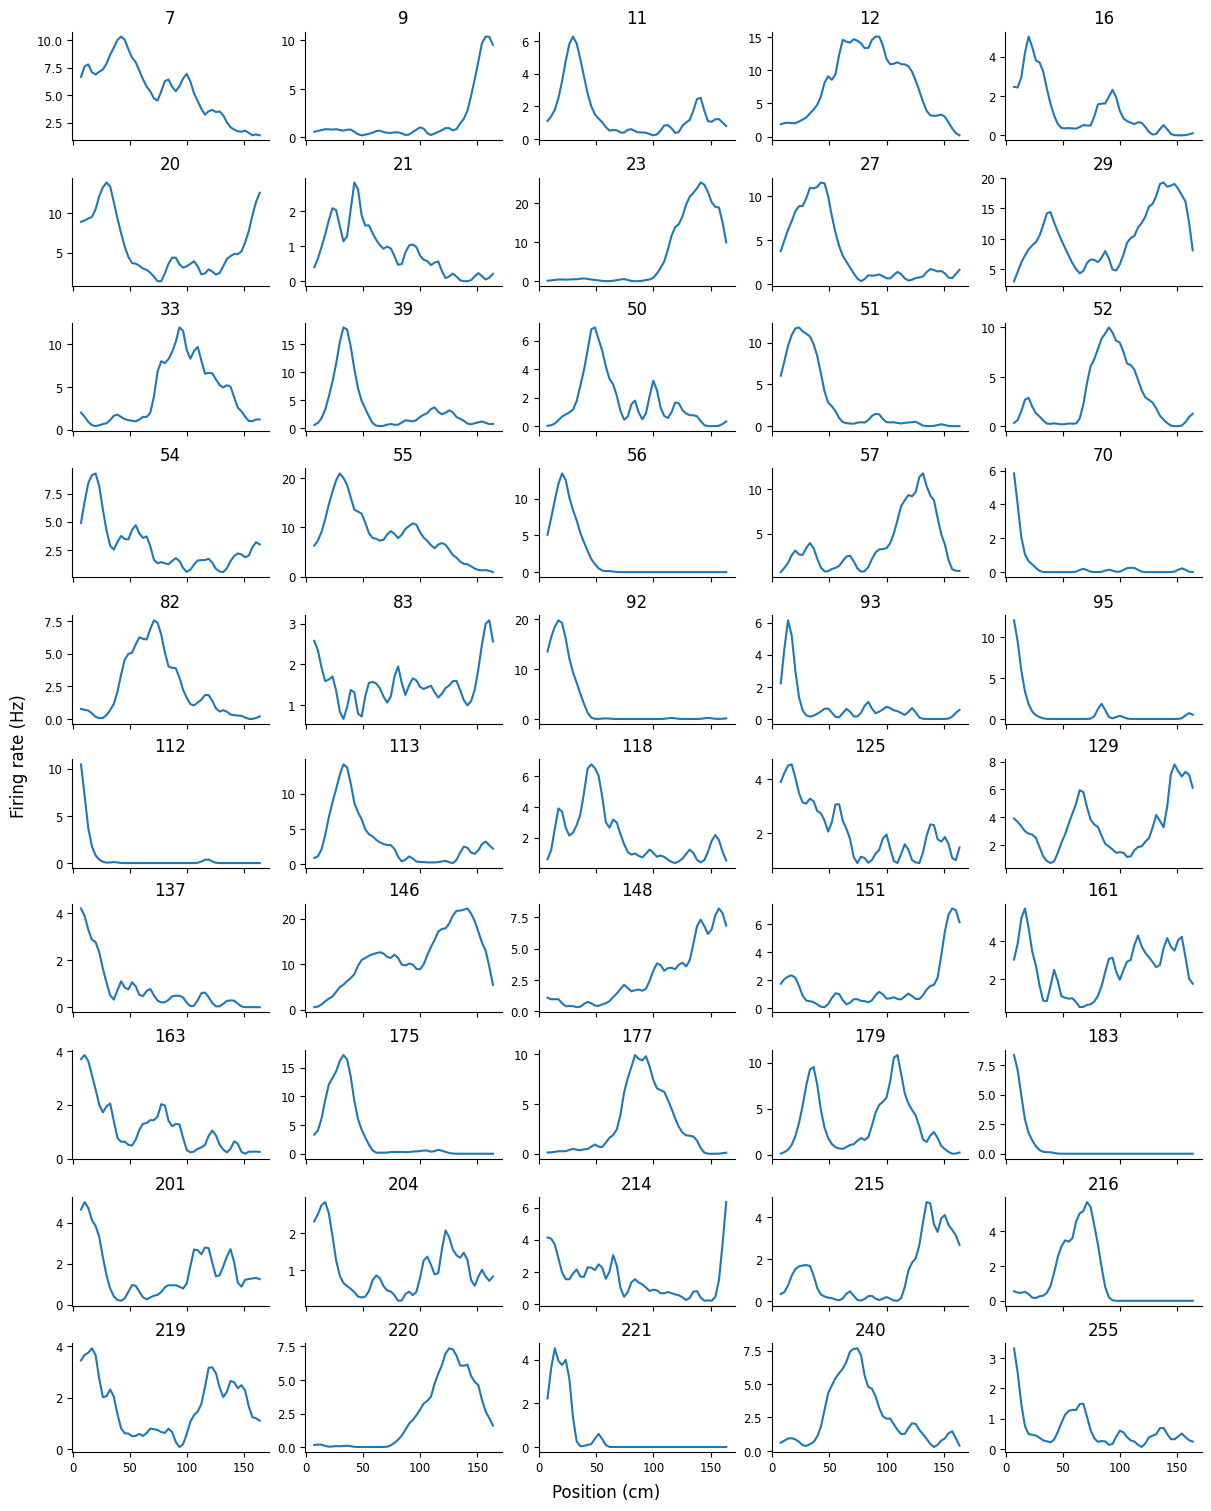

In [19]:
fig, axs = plt.subplots(10, 5, figsize=(12, 15), sharex=True, constrained_layout=True)
for i, (f, fields) in enumerate(place_fields.iloc[:,:50].items()):
    idx = np.unravel_index(i, axs.shape)
    axs[idx].plot(fields)
    axs[idx].set_title(f)

fig.supylabel("Firing rate (Hz)")
fig.supxlabel("Position (cm)")

We can see spatial selectivity in each of the units; across the population, we have firing fields tiling the entire linear track. 

To look at phase precession, we'll zoom in on unit 177. This unit has a single strong firing field in the middle of the track, which will be conducive for visualizing phase precession.

***
Computing phase precession within a single unit
-----------------------------------------------
As a first visualization of phase precession, we'll look at a single traversal of the linear track. We'll want the corresponding phase of theta at which the unit fires as the animal is running down the track, which we can compute using a pynapple object's method `value_from`. For our spiking data, this will find the phase value closest in time to each spike.

In [20]:
unit = 177
spike_phase = spikes[unit].value_from(theta_phase)

To see the results, let's plot the theta phase, the spike phase, and the animal's position across the run, as well as the unit's place field as a reminder of it's spatial preference. (Since the relationship between a single run's time and position is nearly linear, the x-axis of position and the x-axis of time will be well-aligned.)

Text(0.5, 1.0, 'Unit 177 place field')

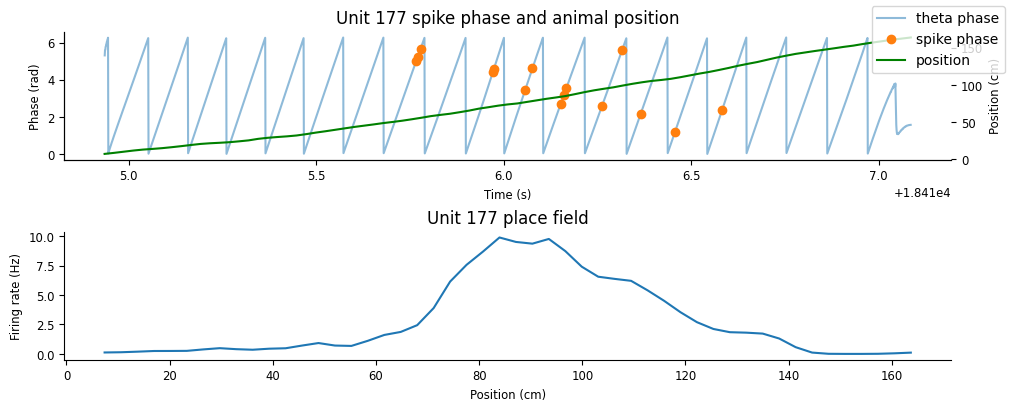

In [21]:
fig,axs = plt.subplots(2,1 , figsize=(10,4), constrained_layout=True)
axs[0].plot(theta_phase.restrict(ex_run_ep), alpha=0.5, label="theta phase")
axs[0].plot(spike_phase.restrict(ex_run_ep), 'o', label="spike phase")
axs[0].set_ylabel("Phase (rad)")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Unit 177 spike phase and animal position")
ax = axs[0].twinx()
ax.plot(ex_position, color="green", label="position")
ax.set_ylabel("Position (cm)")
fig.legend()

axs[1].plot(place_fields[unit])
axs[1].set_ylabel("Firing rate (Hz)")
axs[1].set_xlabel("Position (cm)")
axs[1].set_title("Unit 177 place field")

As expected, unit 177 will preferentially spike (orange dots) as the animal runs through the middle of the track. Additionally, you should be able to see a negative trend in the spike phase as the animal move's further along the track. This phemomena is what is called phase precession: as an animal runs through the place field of a single unit, that unit will spike at *late* phases of theta (higher radians) in *earlyr* positions in the field, and fire at *early* phases of theta (lower radians) in *late* positions in the field.

We can observe this phenomena on average across all runs by relating the spike phase to the spike position. Similar to before, we'll use the pynapple object method `value_from` to additionally find the animal position closest in time to each spike.

In [22]:
spike_position = spikes[unit].value_from(position)

Now we can plot the spike phase against the spike position in a scatter plot.

Text(0.5, 0, 'Position (cm)')

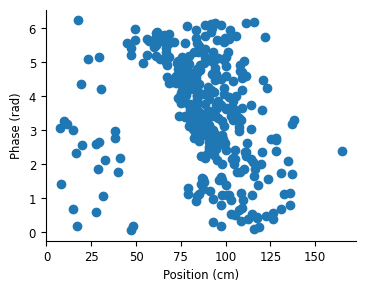

In [23]:
plt.subplots(figsize=(4,3))
plt.plot(spike_position, spike_phase, 'o')
plt.ylabel("Phase (rad)")
plt.xlabel("Position (cm)")

Similar to what we saw in a single run, there is a negative relationship between theta phase and field position, characteristic of phase precession.

***
Decoding position from spiking activity
---------------------------------------
Next we'll do a popular analysis in the rat hippocampal sphere: Bayesian decoding. This analysis is an elegent application of Bayes' rule in predicting the animal's location (or other behavioral variables) from neural activity at some point in time. 

### Background
Recall Bayes' rule, written here in terms of our relevant variables:

$$P(position|spikes) = \frac{P(position)P(spikes|position)}{P(spikes)}$$

Our goal is to compute the unknown posterior $P(position|spikes)$ given known prior $P(position)$ and known likelihood $P(spikes|position)$. 

$P(position)$, also known as the *occupancy*, is the probability that the animal is occupying some position. This can be computed exactly by the proportion of the total time spent at each position, but in many cases it is sufficient to estimate the occupancy as a uniform distribution, i.e. it is equally likely for the animal to occupy any location.

The next term, $P(spikes|position)$, which is the probability of seeing some sequence of spikes across all neurons at some position. Computing this relys on the following assumptions:
1. Neurons fire according to a Poisson process (i.e. their spiking activity follows a Poisson distribution)
2. Neurons fire independently from one another.

While neither of these assumptions are strictly true, they are generally reasonable for pyramidal cells in hippocampus and allow us to simplify our computation of $P(spikes|position)$

The first assumption gives us an equation for $P(spikes|position)$ for a single neuron, which we'll call $P(spikes_i|position)$ to differentiate it from $P(spikes|position) = P(spikes_1,spikes_2,...,spikes_i,...,spikes_N|position) $, or the total probability across all $N$ neurons. The equation we get is that of the Poisson distribution:
$$
P(spikes_i|position) = \frac{(\tau f_i(position))^n e^{-\tau f_i(position)}}{n!}
$$
where $f_i(position)$ is the firing rate of the neuron at position $(position)$ (i.e. the tuning curve), $\tau$ is the width of the time window over which we're computing the probability, and $n$ is the total number of times the neuron spiked in the time window of interest.

The second assumptions allows us to simply combine the probabilities of individual neurons. Recall the product rule for independent events: $P(A,B) = P(A)P(B)$ if $A$ and $B$ are independent. Treating neurons as independent, then, gives us the following:
$$
P(spikes|position) = \prod_i P(spikes_i|position)
$$

The final term, $P(spikes)$, is inferred indirectly using the law of total probability:

$$P(spikes) = \sum_{position}P(position,spikes) = \sum_{position}P(position)P(spikes|position)$$

Another way of putting it is $P(spikes)$ is the normalization factor such that $\sum_{position} P(position|spikes) = 1$, which is achived by dividing the numerator by its sum.

If this method looks daunting, we have some good news: pynapple has it implemented already in the function `nap.decode_1d` for decoding a single dimension (or `nap.decode_2d` for two dimensions). All we'll need are the spikes, the tuning curves, and the width of the time window $\tau$.

### Cross-validation

Generally this method is cross-validated, which means you train the model on one set of data and test the model on a different, held-out data set. For Bayesian decoding, the "model" refers to the model *likelihood*, which is computed from the tuning curves. 

We want to decode the example run we've been using throughout this exercise; therefore, our training set should omit this run before computing the tuning curves. We can do this by using the IntervalSet method `set_diff`, to take out the example run epoch from all run epochs.

In [24]:
# hold out trial from place field computation
run_train = data["forward_ep"].set_diff(ex_run_ep)

Next, we'll restrict our data to these training epochs and re-compute the place fields using `nap.compute_1d_tuning_curves`. Similar to before, we'll applying a Gaussian smoothing filter to the place fields, which will smooth our decoding results down the line.

In [25]:
position_train = data["position"].restrict(run_train)
place_fields = nap.compute_1d_tuning_curves(spikes, position_train, nb_bins=50)
place_fields[:] = gaussian_filter1d(place_fields.values, 1, axis=0)

### Run decoder

This is the minumum needed to run the `nap.decode_1d` function. The first input will be our tuning curves (place fields), the second input is the `TsGroup` of spike times corresponding to units in the tuning curve DataFrame (this can also be a `TsdFrame` of spike counts), the third input is the epoch we want to decode, and the fourth input is the bin size, or the time resolution $\tau$ at which to decode.

In [26]:
decoded_position, decoded_prob = nap.decode_1d(place_fields, spikes, ex_run_ep, bin_size=0.2)

The first output is the inferred position from the decoder, and the second output is the posterior distribution, giving the probability distribution of position given the spiking activity. (The decoded position is simply the position at which the probability is greatest.)

Let's plot the posterior distribution and overlay the animal's true position.

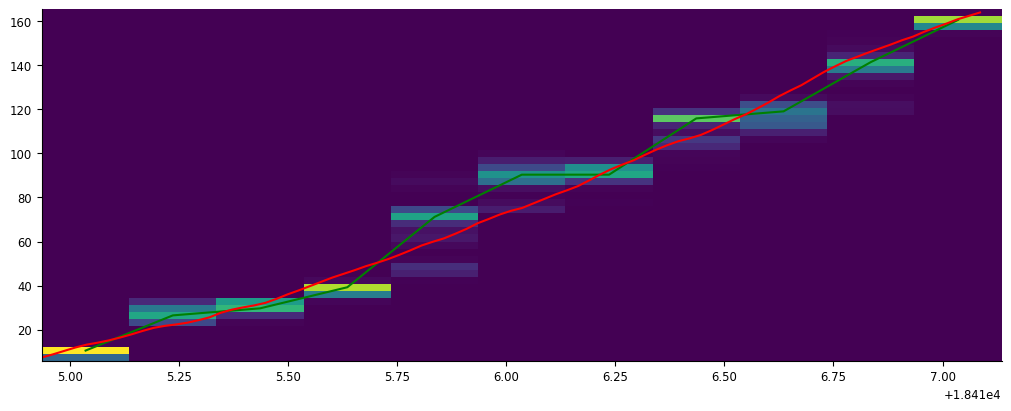

In [27]:
plt.subplots(figsize=(10, 4), constrained_layout=True)
plt.pcolormesh(decoded_position.index,place_fields.index,np.transpose(decoded_prob))
plt.plot(decoded_position, color="green")
plt.plot(ex_position, color="red")

The decoder does a reasonable job at following the animals true position, but gets worse at shorter bin sizes.

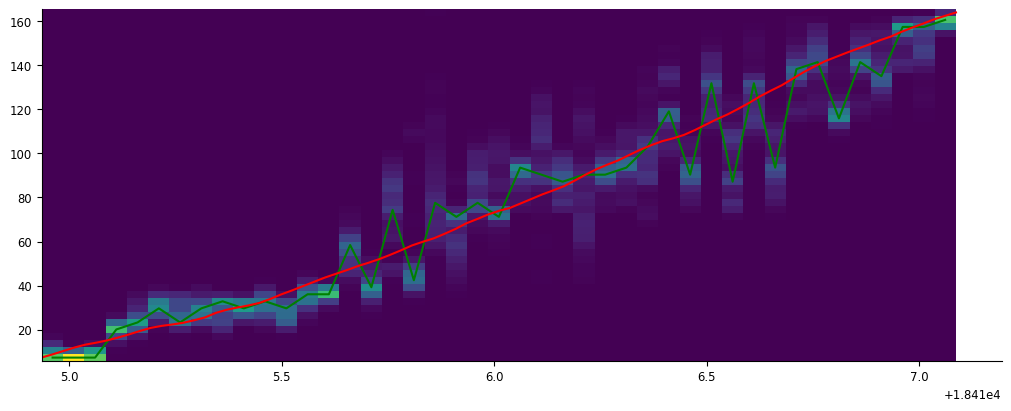

In [28]:
decoded_position, decoded_prob = nap.decode_1d(place_fields, spikes, ex_run_ep, bin_size=0.05)
plt.subplots(figsize=(10, 4), constrained_layout=True)
plt.pcolormesh(decoded_position.index,place_fields.index,np.transpose(decoded_prob))
plt.plot(decoded_position, color="green")
plt.plot(ex_position, color="red")

### Smooth spike counts for decoder

One way to improve our estimation at shorter bin sizes is to instead use *sliding windows* to bin our data. This allows us to combine the accuracy of a larger bin size with the resolution of a smaller bin size by essentially smoothing the spike counts. This is a feature that will be added in a future version of pynapple, but we can still apply it ourselves by providing the spike counts directly to `nap.decode_1d` as a `TsdFrame`.

Let's say we want a sliding window of $200 ms$ that shifts by $50 ms$. We can compute this efficiently by first binning at the smaller $50 s$ bin size, which we can do by applying the pynapple object method `count`.

In [29]:
counts = spikes.restrict(ex_run_ep).count(0.05)

Next, we apply a moving sum on each set of $200 ms / 50 ms = 4$ adjacent bins to "smooth" each count into $200 ms$ bins. This is the same as convolving the counts with a length 4 kernel of ones.

In [30]:
smth_counts = counts.convolve(np.ones(4))

To see this in action, we've provided an animation to visualize the convolution on a single unit. In the top figure, we'll see the original counts that have been binned in $50ms$ windows as well as the kernel representing the moving sum as it slides acorss the trial. When the kernel meets the binned counts, the convolution is equal to the integral of $kernel * counts$, or the sum of the shaded green area. The result of the convolution is in the bottom plot, a smoothed version of the counts in the top plot.

In [31]:
nac.animate_1d_convolution(counts.loc[177], np.ones(4), tsd_label="original counts", kernel_label="moving sum", conv_label="convolved counts")

Let's use `nap.decode_1d` again, but now with our smoothed counts in place of the raw spike times. Note that the bin size we'll want to provide the the larger bin size, $200ms$, since this is the true width of each bin.

In [32]:
smth_decoded_position, smth_decoded_prob = nap.decode_1d(place_fields, smth_counts, ex_run_ep, bin_size=0.2)

Let's plot the results.

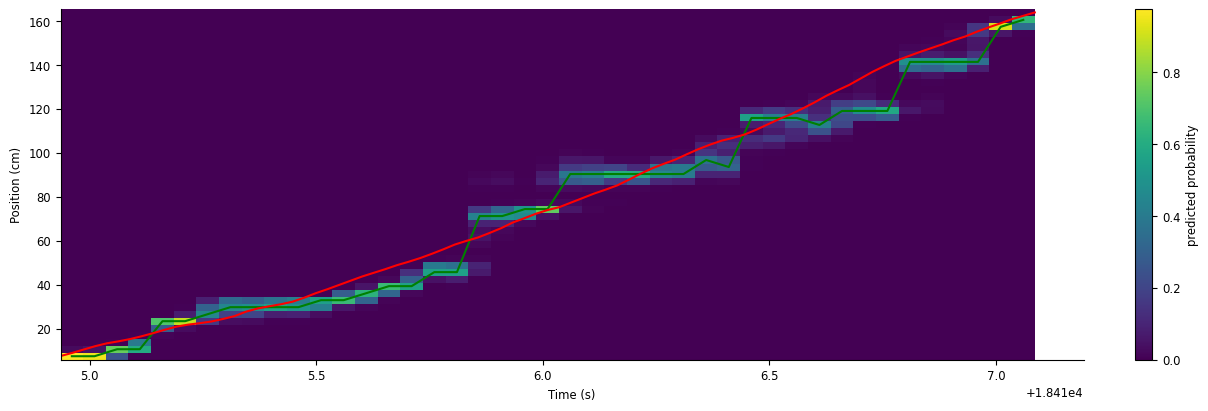

In [33]:
plt.subplots(figsize=(12, 4), constrained_layout=True)
plt.pcolormesh(smth_decoded_prob.index, smth_decoded_prob.columns, np.transpose(smth_decoded_prob))
plt.plot(smth_decoded_position, color="green")
plt.plot(ex_position, color="r")
plt.xlabel("Time (s)")
plt.ylabel("Position (cm)")
plt.colorbar(label = "predicted probability")

We can see a much smoother estimate of position, as well as a smoother posterior probability of position.

### Bonus: theta sequences
Units phase precessing together creates fast, spatial sequences around the animal's true position. We can reveal this by decoding at an even shorter time scale, which will appear as errors in the decoder.

Text(0.5, 0.01, 'Time (s)')

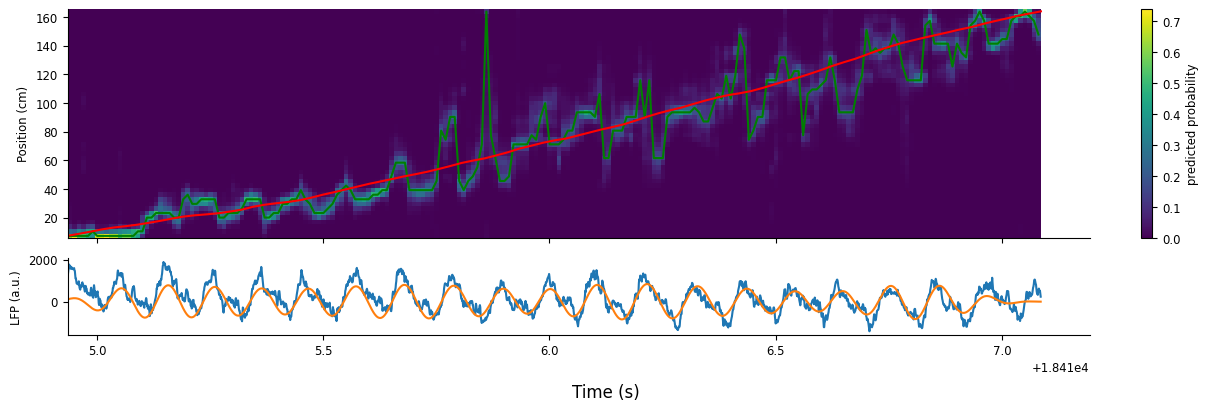

In [34]:
counts = spikes.restrict(ex_run_ep).count(0.01)
smth_counts = counts.convolve(np.ones(4))
smth_decoded_position, smth_decoded_prob = nap.decode_1d(place_fields, smth_counts, ex_run_ep, bin_size=0.04)

fig, axs = plt.subplots(2, 1, figsize=(12, 4), constrained_layout=True, height_ratios=[3,1], sharex=True)
c = axs[0].pcolormesh(smth_decoded_prob.index, smth_decoded_prob.columns, np.transpose(smth_decoded_prob))
axs[0].plot(smth_decoded_position, color="green")
axs[0].plot(ex_position, color="r")
# axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Position (cm)")
fig.colorbar(c, label = "predicted probability")

axs[1].plot(ex_lfp_run)
axs[1].plot(theta_band.restrict(ex_run_ep))
axs[1].set_ylabel("LFP (a.u.)")

fig.supxlabel("Time (s)")

The estimated position oscillates with cycles of theta, where each "sweep" is referred to as a "theta sequence". Fully understanding this organization of place cells and its role in learning, memory, and planning is an active topic of research in Neuroscience!